# Designing a 4-rod trap for $^{171}$Yb$^+$ ions
Your goal is to design an ion trap that can be used for performing trapped ion QIP experiments. See the figure below to understand the different parameters that characterize the trap.

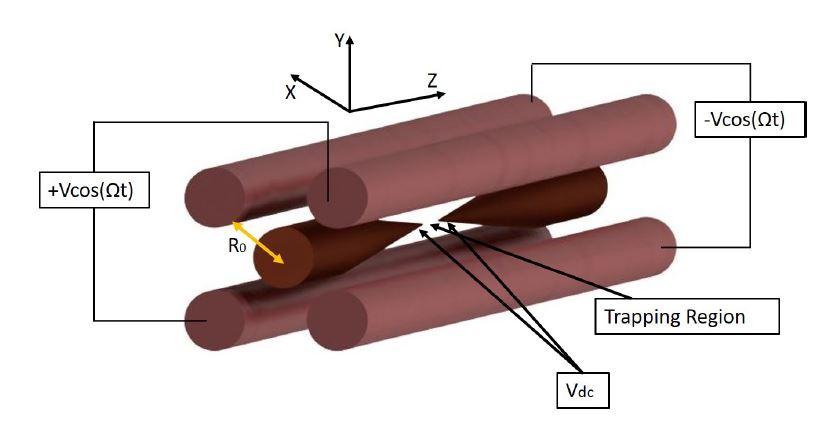

* V: Amplitude of the RF voltage on the rods (for confinement in the XY plane)
* V$_{dc}$: DC voltage on the needle elctrodes(end caps for confinement along Z) 
* $R_0$: Ion - electrode distance 
* $\Omega$: Frequency of oscillation of rod voltages

While setting the values of different parameters in the trap the following points need to be considered
* The spacing between the rods should be small enought so that there is a lot of room to collect the ion fluorescence
* The trap should be stable ( for $^{171}$Yb$^+$)
* $\omega_{x/y}$ should be determined based on the physics application



## Design Constraints
Let us assume we have the following constraints for the trap
* NA = 0.58 for good light collection ( this affects the detection fidelity of the ion qubits)
* q$_x$ $\leq$ 0.2 ( This ensures that the trap is stable)
* $\omega_x$  = 2$\pi$ $\sqrt2$ MHz ( Assume this came out of thin air for now!)
* 20 ions need to be confined within 50 micron in the ion chain direction ( This is because the imaging system for the ions has a finite field of view)

### Step 1: Find $R_0$ for NA ~ 0.58
Use the following figure to calculate the value of S for NA = 0.58 and d = 0.5mm (We chose this value of d because this is the smallest commercially available rod diameter)

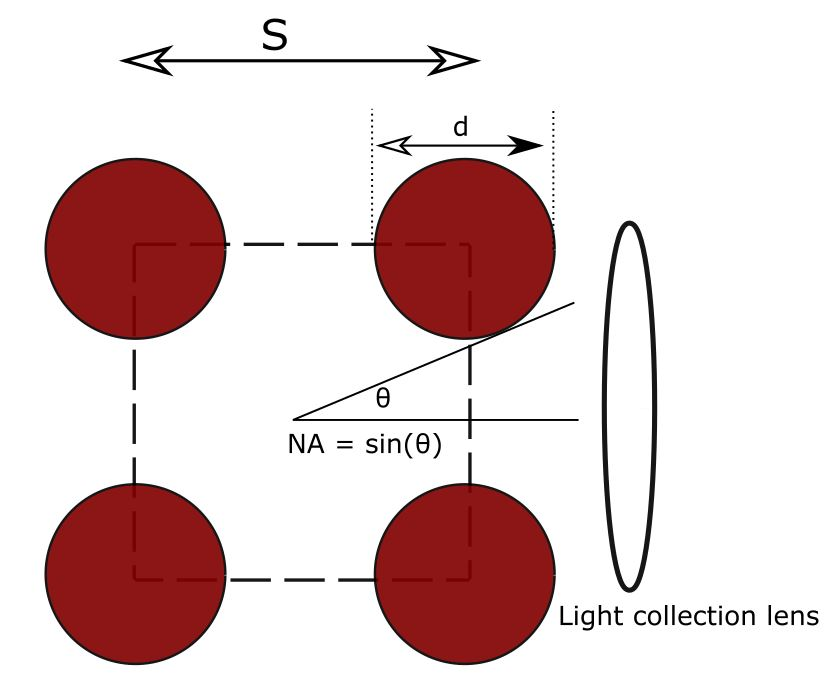

From this calculate the parameter $R_0$ ( see previous figure for definition of $R_0$ )


### Step 2: Find  $\Omega$ to achieve q$_x$ $\leq$ 0.2
The expression for the trap stability parameter and the secular frequancy are the folowing ( assuming $\eta$ = 1)

$q_x = \frac{2qV}{m \Omega^2 R_0^2} $

$w_x = \frac{qV}{\sqrt2 m \Omega R_0^2}$

Given the above expressions, derive an inequality of the form $\Omega \geq a \omega_x$ and find the value of a. Now find the value of $\Omega$ given that w$_x$  = 2$\pi$ $\sqrt2$ MHz

### Step 3: Find V to achieve $\omega_x$  = 2$\pi$ $\sqrt2$ MHz
Since we calculated the value of $\Omega$ in the previous step the only variable left is V. Use the code cells below to check your calculations

In [1]:
import sympy as sp
e = 1.60217662*10E-19 # charge of an electron
amu = 1.66054e-27 # atomic mass unit

In [2]:
q_x,w,q,V,m,Omega,R = sp.symbols('q_x w q V m \Omega R_0', real = True)

In [3]:
w_x = 1/sp.sqrt(2) * q * V/(m * Omega * R**2)
q_x = 2 * q * V / (m * Omega**2 * R**2)

In [4]:
w_x

sqrt(2)*V*q/(2*R_0**2*\Omega*m)

In [5]:
q_x 

2*V*q/(R_0**2*\Omega**2*m)

Substituting values into the expression for $\omega_x$

In [6]:
(w_x.subs([(V,55),(q,e ),(R,5E-3),\
                    (m,171*amu) , (Omega,2*sp.pi*20E6)])/(2*sp.pi)).evalf() # everything in SI units


11116.8792534098

Substituting values into the expression for $q_x$

In [7]:
(q_x.subs([(V,200),(q,1.60217662*(10**(-19) ) ),(R,5E-3),\
          (m,2.8395214559472*10**(-25)) , (Omega,2*sp.pi*20E6)])).evalf() # everything in SI units

0.000571696442731506

### Step 4: Set $\omega_z$ such that the ions are tightly confined
We wanted 20 ions to be confined within 50 micron in the ion chain direction. For this we need to make sure that the trapping strength in the Z-direction is enough to achieve this. This will be ensured by setting an appropriate value for $\omega_z$.

#### Some math for calculating ion equilibrium positions
Assuming tight confinement in the X-Y plane we expect the ions to be in a straight line along the Z-axis. Hence we can neglect the contribution of the trapping potential in the X-Y plane and concentrate on the potential along the z-axis for calculating the equilibrium positions

The total potential energy of the n ions is then given as:

$\phi = \phi_{harmomic} + \phi_{coloumb}$

where  

$\phi_{harmomic} = \frac{1}{2} m \omega_z^2 z^2$ 

comes from the confinement created from the DC electrodes (needles) of the trap. And close to the center of the trap this a harmonic oscillator potential at frequency $\omega_z^2$

$\phi_{coloumb} = \sum_{i,j>i} \frac{q^2}{4 \pi \epsilon}\frac{1}{z_j - z_i}$ 

comes from the coloumb interaction between the ions.

We can write the total potential as

$\phi = \sum_i \frac{1}{2} m \omega_z^2 z_i^2 + \sum_{i,j>i} \frac{q^2}{4 \pi \epsilon}\frac{1}{z_j - z_i}$

The code below simply minimizes this potential when there are n ions in the trap and generates the equilibrium positions of the ions along the Z-axis


In [8]:
# Run this cell and IGNORE the code. 
# This is only required to make sure the optimizer work
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
q = 1.60217662*(10**(-19)) # one unit of charge
m = 2.8395214559472*10**(-25) # mass of Yb171
K = 8987551788.7 #1/(4 pi E_0)
L = 10**(-6)

def phi_harmonic_z(z_pos,z_freq):
    omega = 2*np.pi*z_freq
    pot = 0.5*((m*omega**2*L**3)/(K*q**2))*z_pos**2 # written weirdly because of how the potential scales 
    return pot

def phi_coul(z_pos):
        # takes a vector(z_pos) containing z coordinates of len(z_pos) ions
        # returns the coulomb energy between then in units of joules
    phi = 0 # in the units of volts
    for i in range(0,z_pos.size):
        for j in range(i+1,z_pos.size):
            phi += (1/(z_pos[j]-z_pos[i]))
    return phi 

def phi_total_ideal(z_pos,z_freq):
    return np.sum(phi_harmonic_z(z_pos,z_freq)) + phi_coul(z_pos)

def plot_ideal_positions(n_ions,z_guess,z_freq):
    # takes number of ions n_ions
    # outputs the equilibrium positions of the ions in um 
    # Also plots the equilibrium positions and the seperation b/w ions
    # assumes that the trapping potential is harmonic
    n = n_ions
    z_ions = z_guess
    
    y = np.linspace(1,1,n)
    bnds = [[-350,350]]*n # bounds for the solution space
    def f_factory(i):
        '''
        generates constraining funstions for optimize.minimize
        '''
        return lambda x: x[i+1] - x[i]
    con_set = []
    for i in range(0,n-1):
        con_set.append({'type' : 'ineq', 'fun': f_factory(i)})
    res = optimize.minimize(phi_total_ideal,z_ions,z_freq,method = 'SLSQP',options={'maxiter':1000},\
                        bounds=bnds,constraints=con_set,tol = 1e-6)
    print(res.message)
    
    fig = plt.figure(figsize=(16,1))
    ax1 = fig.add_subplot(111)
    ax1.plot(res.x,y,'*')
    ax1.set_xlabel('μm')
    ax1.yaxis.set_visible(False)
    plt.show()

    return res.x

Optimization terminated successfully


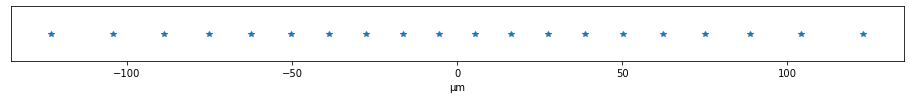

array([-122.87300814, -104.19624342,  -88.77401163,  -75.03159354,
        -62.25491709,  -50.3073316 ,  -38.76096483,  -27.52182817,
        -16.43899465,   -5.49764546,    5.49356077,   16.44595806,
         27.51962428,   38.75292348,   50.32039113,   62.24713878,
         75.03470645,   88.77419343,  104.19632317,  122.873106  ])

In [9]:
n = 20
z_guess = np.linspace(-200,200,n)
w_z = 0.03*10**6 # this is freq not angular freq hence no 2*pi
plot_ideal_positions(n,z_guess,z_freq=w_z)

### Food for thought
Congratulations on designing a 4-rod trap usable for quantum information processing. In fact this is very much the design we have at the QITI lab (apart from the exact values of V and $\Omega$). But before you celebrate here are a few points to ponder over
* Is this analysis complete ? What are we missing here ?
* Do the ions look like they are evenly spaced ? Try with a larger number of ions in the above cell!
* How is a system for QIP different from the dust trap ?
* What would you do to trap ions in a plane and not a line ?
